The ability of DCGANs to learn hierarchical representations of the input, which enables them to produce extremely detailed pictures, is one of its main advantages and the reason I picked it. In order to stabilise the training process and lessen mode collapse, it employs a batch normalisation in both the generator and discriminator. Instead of pooling, I utilised layers that convolute with strides to lower the image's resolution since it gives the network more freedom to develop its own pooling technique. 

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.parallel
import torchvision.utils as vutils
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [156]:
path = "symbols_dataset" #or the path to the folder with the same data set for question 3 without class 0
transforms = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(64), transforms.CenterCrop(64),
                               transforms.ToTensor()])
dataset = ImageFolder(root=path, transform=transforms)
dloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [157]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

The weights init function initialises the weights randomly from a normal distribution with a mean of 0 and a standard deviation of 0.02, as suggested by the authors of the DCGAN paper.

In [158]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(110, 512, 4, 1, 0, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),           
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 1, 4, 2, 1, bias=False),
            nn.Tanh()  )

    def forward(self, ip):
        return self.main(ip)

In [159]:
netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [160]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential( 
            nn.Conv2d(1, 64, 4, 2, 1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),   
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),   
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),  
            nn.Sigmoid() )

    def forward(self, input):
        return self.main(input)

In [161]:
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [162]:
loss_func = nn.BCELoss()
flabel = 0.
rlabel = 1.
e = 7
b1 = 0.5
b2 = 0.999
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(b1, b2))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(b1, b2))

I decided to utilise ADAM as the optimizer for both the generator and discriminator because ADAM produced far superior results than other optimizers. I kept the number of feature mappings in both the generator and discriminator layers modest since they are not very complicated.

In [163]:
for epoch in range(e):
    for i, d in enumerate(dloader, 0):

        netD.zero_grad()
        rdata = d[0].to(device)
        s = rdata.size(0)
        lbl = torch.full((s,), rlabel, dtype=torch.float, device=device)
        op1 = netD(rdata).view(-1)
        errD_r = loss_func(op1, lbl)
        errD_r.backward()
        noise = torch.randn(s, 110, 1, 1, device=device)
        fdata = netG(noise)
        lbl.fill_(flabel)
        op2 = netD(fdata.detach()).view(-1)
        errD_f = loss_func(op2, lbl)
        errD_f.backward()
        errD = errD_r + errD_f
        optimizerD.step()
        netG.zero_grad()
        lbl.fill_(rlabel)
        op3 = netD(fdata).view(-1)
        errG = loss_func(op3, lbl)
        errG.backward()
        optimizerG.step()

        if i % 17 == 0 or ((epoch == e-1) and (i == len(dloader))):
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % 
                  (epoch+1, e, i, len(dloader), errD.item(), errG.item(), op1.mean().item(), op2.mean().item(), op3.mean().item()))

        if  (i == len(dloader)) and (epoch == e-1):
          noise = torch.randn(64, 110, 1, 1, device=device)
          with torch.no_grad():
            f = netG(noise).detach().cpu()
          final_output = vutils.make_grid(f, padding=2, normalize=True)

[1/7][0/85]	Loss_D: 1.8308	Loss_G: 2.3254	D(x): 0.3195	D(G(z)): 0.3344 / 0.1321
[1/7][17/85]	Loss_D: 0.2141	Loss_G: 12.6822	D(x): 0.9770	D(G(z)): 0.1600 / 0.0000
[1/7][34/85]	Loss_D: 0.0194	Loss_G: 32.3665	D(x): 0.9888	D(G(z)): 0.0000 / 0.0000
[1/7][51/85]	Loss_D: 0.1443	Loss_G: 9.4201	D(x): 0.9421	D(G(z)): 0.0199 / 0.0002
[1/7][68/85]	Loss_D: 0.5238	Loss_G: 16.8133	D(x): 0.8816	D(G(z)): 0.0007 / 0.0000
[2/7][0/85]	Loss_D: 0.4532	Loss_G: 5.6790	D(x): 0.7901	D(G(z)): 0.0010 / 0.0155
[2/7][17/85]	Loss_D: 0.9242	Loss_G: 2.7615	D(x): 0.6231	D(G(z)): 0.0097 / 0.1268
[2/7][34/85]	Loss_D: 0.2216	Loss_G: 7.5692	D(x): 0.9463	D(G(z)): 0.0993 / 0.0038
[2/7][51/85]	Loss_D: 0.9099	Loss_G: 15.8182	D(x): 0.9502	D(G(z)): 0.4438 / 0.0000
[2/7][68/85]	Loss_D: 0.4766	Loss_G: 5.4261	D(x): 0.7891	D(G(z)): 0.0086 / 0.0167
[3/7][0/85]	Loss_D: 0.2550	Loss_G: 7.5478	D(x): 0.8894	D(G(z)): 0.0285 / 0.0036
[3/7][17/85]	Loss_D: 0.4936	Loss_G: 6.4490	D(x): 0.8762	D(G(z)): 0.2010 / 0.0072
[3/7][34/85]	Loss_D: 0.3348

During training:

1 - I run a forward pass with a batch of real data and calculate the gradients in a backward pass. 

2 - I repeat the process with a batch of fake data that was generated using the current generator, computing the gradient as the total sum of gradients from the fake and real data, and updating the discriminator using the optimizer.

3 - I try to maximise the Log of D(G(x)) for the generator rather than minimise the Log of 1 - D(G(x) by running the fictitious data through the discriminator once more and labelling it as real data (D stands for Discriminator and G stands for Generator)

4 - I update the generator's loss using that output, calculating the gradients for it

5 - then running the optimizer step.

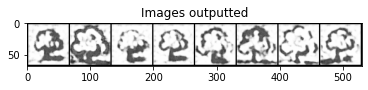

In [926]:
n = torch.randn(8, 110, 1, 1, device=device)
with torch.no_grad():
    f = netG(n).detach().cpu()
op = vutils.make_grid(f, padding=2, normalize=True)
plt.title("Images outputted")
plt.imshow(np.transpose(op,(1,2,0)))

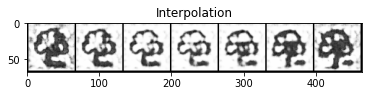

In [944]:
n = torch.randn(2, 110, 1, 1).cpu()
steps = torch.tensor(np.logspace(n[0],n[1], 7)).to(device)

with torch.no_grad():
    f = netG(steps).detach().cpu()

op = vutils.make_grid(f, padding=2, normalize=True)

plt.title("Interpolation")
plt.imshow(np.transpose(op.cpu(),(1,2,0)))

In [945]:
torch.save(netG.state_dict(), 'G_weights.pkl')
torch.save(netD.state_dict(), 'D_weights.pkl')